In [1]:
from PIL import Image
from PIL.ImageOps import invert
image = Image.open("/media/mlfavorfit/sdb/contolnet_dataset/control_net_train_outpaint/images/nike_1511_white.jpg").convert("RGB")
mask = Image.open("/media/mlfavorfit/sdb/contolnet_dataset/control_net_train_outpaint/masks/nike_1511_white.jpg").convert("L")
object_image = Image.open("/media/mlfavorfit/sdb/contolnet_dataset/control_net_train_outpaint/conditioning_images/nike_1511_white.jpg").convert("RGB")

# image = Image.open("/media/mlfavorfit/sda/product_512/image/nike_1326_apair.jpg")
# mask = Image.open("/media/mlfavorfit/sda/product_512/mask/nike_1326_apair.jpg")
# object_image = Image.open("/media/mlfavorfit/sdb/contolnet_dataset/control_net_train_outpaint/conditioning_images/nike_1326_apair.jpg").convert("RGB")

inverted_mask = invert(mask)

In [2]:
from PIL import Image
import numpy as np

bin_mask = Image.fromarray(np.where(np.array(mask)> 127, 255, 0).astype(np.uint8))

from utils import make_outpaint_condition, composing_output

bin_object_image = make_outpaint_condition(image, bin_mask.convert("RGB"))

In [3]:
import torch
import os
import random
from transformers import CLIPImageProcessor, CLIPVisionModelWithProjection
from diffusers import DDPMScheduler, UNet2DConditionModel, VQModel, KandinskyV22PriorPipeline
from diffusers.models.controlnet_kandinsky import ControlNetModel
from diffusers.pipelines.kandinsky2_2.pipline_kandinsky2_2_controlnet_inpainting_split import KandinskyV22ControlnetInpaintPipeline
from diffusers.pipelines.kandinsky2_2.pipline_kandinsky2_2_controlnet_split import KandinskyV22ControlnetPipeline

/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
decoder_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-decoder"
prior_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-prior"

In [5]:
movq = VQModel.from_pretrained(
            decoder_model_path, subfolder="movq", torch_dtype=torch.float16
        ).eval()
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    prior_model_path, subfolder="image_encoder", torch_dtype=torch.float16
).eval()
unet = UNet2DConditionModel.from_pretrained(
    decoder_model_path, subfolder="unet", torch_dtype=torch.float16
).eval()
# controlnet = ControlNetModel.from_config(os.path.join(decoder_model_path, "controlnet/config.json"))
controlnet = ControlNetModel.from_pretrained(decoder_model_path, subfolder="controlnet")

The config attributes {'center_input_sample': False, 'out_channels': 8} were passed to ControlNetModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [6]:
prior_pipeline = KandinskyV22PriorPipeline.from_pretrained(
        prior_model_path,
        image_encoder=image_encoder,
        use_safetensors=True,
        torch_dtype=torch.float16,
    )

pipeline = KandinskyV22ControlnetPipeline.from_pretrained(
        decoder_model_path,
        unet=unet,
        movq=movq,
        controlnet=controlnet,
        torch_dtype=torch.float16,
    )

Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00, 566.44it/s]


100%|██████████| 50/50 [00:08<00:00,  5.60it/s]


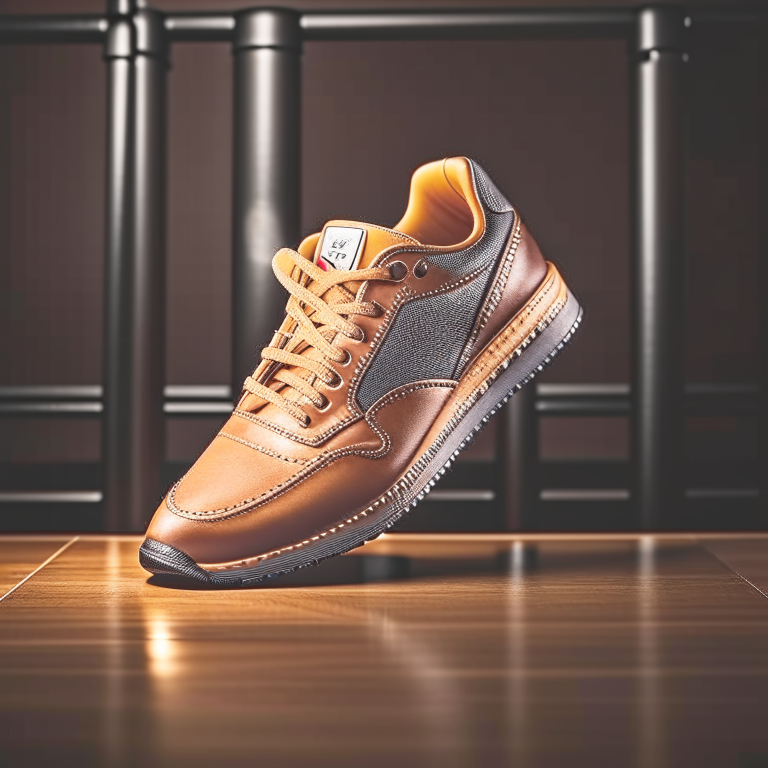

In [12]:
prior_pipeline = prior_pipeline.to("cuda")
pipeline = pipeline.to("cuda")

prompt = "a shoe, product photo, professional photography, room"
negative_prior_prompt = "low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts,nsfw, paintings, sketches, text, watermark, username, spikey"

generator = torch.Generator(device="cuda").manual_seed(43)

with torch.autocast("cuda", torch.float16):
    prior_output = prior_pipeline(
        prompt=prompt, negative_prompt=negative_prior_prompt, generator=generator
    )

    output_image = pipeline(image=bin_object_image,
                            control_image=bin_object_image,
                            **prior_output,
                            height=768,
                            width=768,
                            num_inference_steps=50,
                            strength=1.0,
                            guidance_scale=4.0,
                            controlnet_scale=2.0,
                            generator=generator).images[0]

output_image

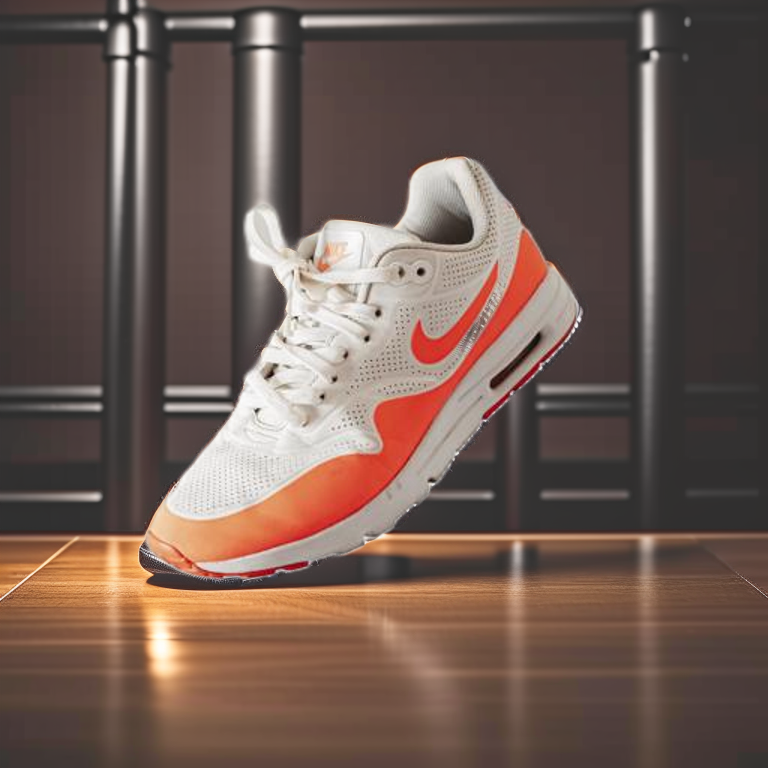

In [13]:
composing_output(output_image, image.resize([768,768]), mask.resize([768,768]).convert("RGB"))